## Import Libraries

In [62]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [3]:
df = pd.read_csv("Data/data_saudi_used_cars.csv")

In [4]:
df.shape

(5624, 11)

In [5]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
0,Corolla,Abha,Toyota,Manual,Saudi,Standard,2013,1.4,421000,True,0
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [6]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price


In [7]:
# Completeness
df.isnull().sum()

Type           0
Region         0
Make           0
Gear_Type      0
Origin         0
Options        0
Year           0
Engine_Size    0
Mileage        0
Negotiable     0
Price          0
dtype: int64

In [8]:
# Accurecy types
df.dtypes

Type            object
Region          object
Make            object
Gear_Type       object
Origin          object
Options         object
Year             int64
Engine_Size    float64
Mileage          int64
Negotiable        bool
Price            int64
dtype: object

In [9]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = ['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']
numeric_features = ['Year', 'Engine_Size', 'Mileage']

In [10]:
for i in categorical_features:
    print (df[i].value_counts())

Type
Land Cruiser    269
Camry           233
Hilux           207
Accent          174
Yukon           162
               ... 
Nativa            1
360               1
GC7               1
CT5               1
S8                1
Name: count, Length: 347, dtype: int64
Region
Riyadh            2270
Dammam             924
Jeddah             732
Qassim             225
Al-Medina          214
Al-Ahsa            166
Aseer              163
Makkah             153
Taef               103
Tabouk              97
Khobar              76
Abha                64
Jazan               60
Hail                58
Jubail              56
Najran              42
Hafar Al-Batin      39
Al-Baha             35
Yanbu               27
Al-Jouf             27
Arar                22
Besha               16
Qurayyat            13
Al-Namas            12
Wadi Dawasir        12
Sakaka              10
Sabya                4
Name: count, dtype: int64
Make
Toyota          1430
Hyundai          668
Ford             530
Chevrolet     

In [11]:
df = df[df['Year']>=2000]

In [12]:
# Calculate the frequency of each 'Type'
type_counts = df['Type'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Type'].isin(type_counts[type_counts >= 2].index)]

In [13]:
df.shape

(5364, 11)

In [14]:
# Calculate the frequency of each 'Make'
make_counts = df['Make'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['Make'].isin(make_counts[make_counts >=2].index)]

In [15]:
df.shape

(5364, 11)

In [16]:
#df[df['Type']=='Other']

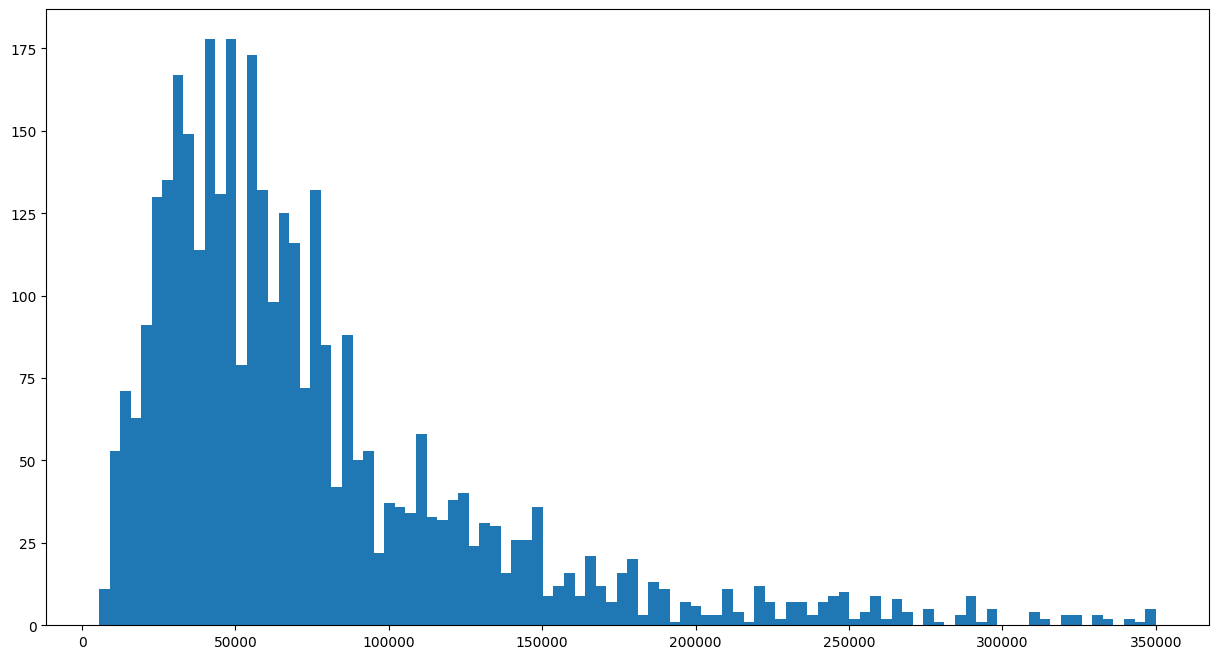

In [17]:
plt.figure(figsize=(15,8))
# plt.boxplot(df['Price']);
plt.hist(df[(df['Price']<=350000) & (df['Price']>5000)]['Price'], bins=100);
#plt.hist(df[(df['Price']<=400000) & (df['Price']>=5000)]['Price'], bins=100);

In [18]:
df = df[(df['Price']<=350000) & (df['Price']>=5000)]

In [19]:
df.shape

(3566, 11)

In [20]:
#df[df['Mileage']<1000]

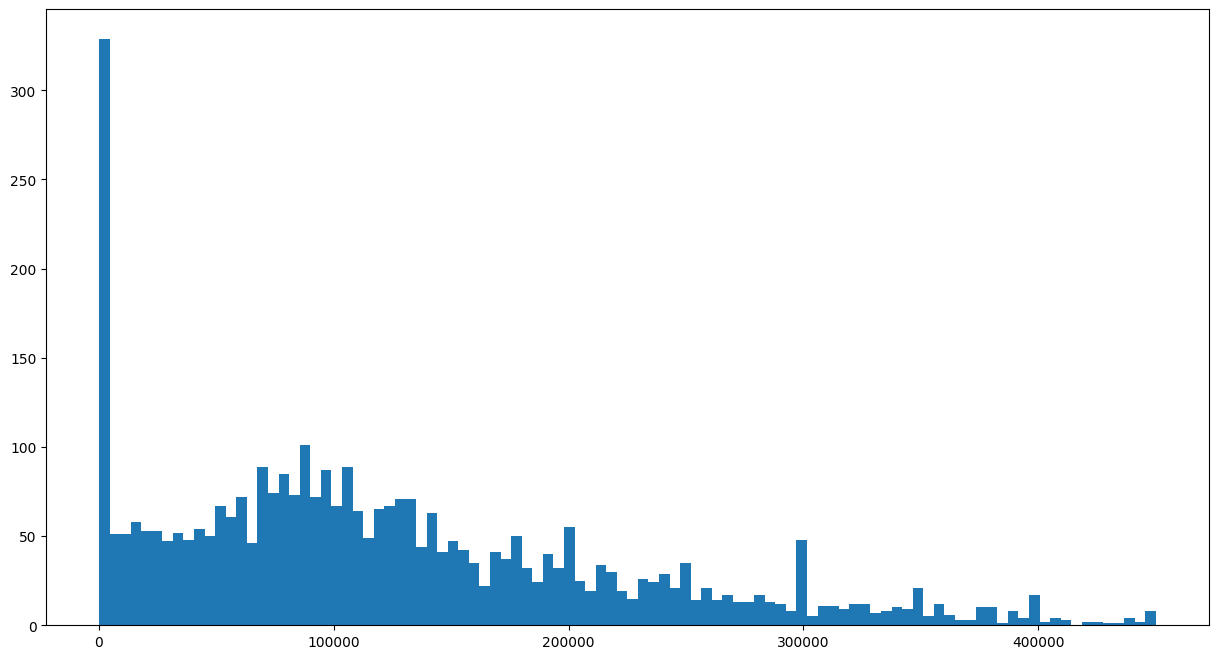

In [21]:
plt.figure(figsize=(15,8))
#plt.boxplot(df['Mileage']);
plt.hist(df[df['Mileage']<=450000]['Mileage'], bins=100);
#plt.hist(df['Mileage'], bins=100);

In [22]:
df = df[df['Mileage']<=450000]
df.shape

(3511, 11)

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [23]:
df.head(2)

,Type,Region,Make,Gear_Type,Origin,Options,Year,Engine_Size,Mileage,Negotiable,Price
1,Yukon,Riyadh,GMC,Automatic,Saudi,Full,2014,8.0,80000,False,120000
2,Range Rover,Riyadh,Land Rover,Automatic,Gulf Arabic,Full,2015,5.0,140000,False,260000


In [24]:
categorical_features

['Type', 'Region', 'Make', 'Gear_Type', 'Origin', 'Options']

In [25]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [26]:
df.shape

(3511, 325)

In [27]:
df.head(2)

,Year,Engine_Size,Mileage,Negotiable,Price,Type_3,Type_300,Type_3008,Type_301,Type_5,...,Make_Zhengzhou,Gear_Type_Automatic,Gear_Type_Manual,Origin_Gulf Arabic,Origin_Other,Origin_Saudi,Origin_Unknown,Options_Full,Options_Semi Full,Options_Standard
1,2014,8.0,80000,False,120000,False,False,False,False,False,...,False,True,False,False,False,True,False,True,False,False
2,2015,5.0,140000,False,260000,False,False,False,False,False,...,False,True,False,True,False,False,False,True,False,False


In [28]:
# Calculate the 35th and 75th percentiles of the price
p35 = df['Price'].quantile(0.35)
p75 = df['Price'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['car_price_category'] = df['Price'].apply(categorize_price)

df.drop('Price', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['car_price_category'].value_counts())

car_price_category
Good_Price     1404
Cheap_Price    1227
High_Price      880
Name: count, dtype: int64


In [29]:
p35, p75

(46000.0, 95000.0)

In [30]:
#df['car_price_category'] 

In [31]:
encoder = LabelEncoder()
df['car_price_category_encoded'] = encoder.fit_transform(df['car_price_category'])  

#### 3. Feature selection

In [32]:
# sns.heatmap(df.corr(), annot=True);

In [33]:
correlation = df.corr(numeric_only=True)
#print(correlation['Price'].sort_values(ascending=False))
print(correlation['car_price_category_encoded'].sort_values(ascending=False))

car_price_category_encoded    1.000000
Year                          0.407525
Engine_Size                   0.334464
Options_Full                  0.305622
Make_Mercedes                 0.225376
                                ...   
Make_Hyundai                 -0.223059
Type_Accent                  -0.237844
Options_Standard             -0.283697
Mileage                      -0.287567
Negotiable                         NaN
Name: car_price_category_encoded, Length: 325, dtype: float64


In [34]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['car_price_category_encoded']) > \
threshold]['car_price_category_encoded'].index
selected_features

Index(['Year', 'Engine_Size', 'Mileage', 'Type_Accent', 'Type_Land Cruiser',
       'Make_Hyundai', 'Make_Mercedes', 'Options_Full', 'Options_Standard',
       'car_price_category_encoded'],
      dtype='object')

In [35]:
selected_features = ['Year', 'Engine_Size', 'Mileage', 'Type_Accent', 'Type_Land Cruiser',
                      'Make_Hyundai', 'Make_Mercedes', 'Options_Full', 'Options_Standard',
                      'car_price_category_encoded']

In [36]:
df = df[selected_features]
df.head()

,Year,Engine_Size,Mileage,Type_Accent,Type_Land Cruiser,Make_Hyundai,Make_Mercedes,Options_Full,Options_Standard,car_price_category_encoded
1,2014,8.0,80000,False,False,False,False,True,False,2
2,2015,5.0,140000,False,False,False,False,True,False,2
3,2015,2.4,220000,False,False,False,False,False,False,0
5,2019,2.0,25000,False,False,False,False,False,False,1
6,2012,4.8,189000,False,False,False,False,True,False,1


#### 4. Prepare train and test data

In [39]:
# Prepare data
X = df.drop(['car_price_category_encoded'], axis=1)
y = df['car_price_category_encoded']


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
X.shape

(3511, 9)

## Buliding the Model

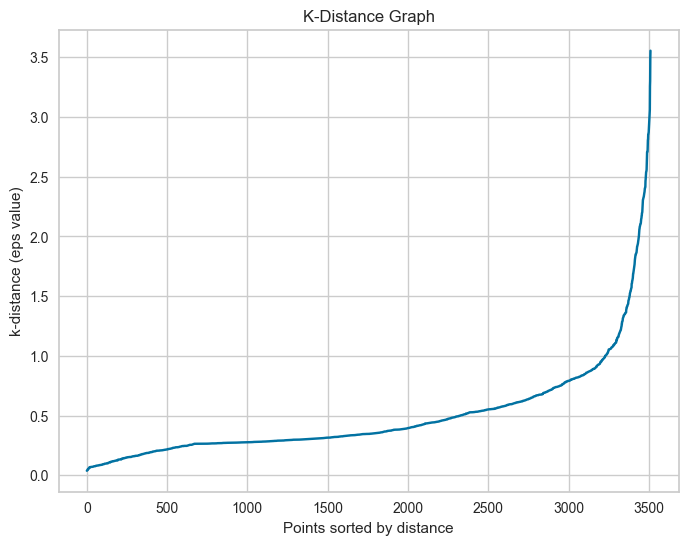

In [119]:
# 2. Use NearestNeighbors to find the optimal eps
min_samples = 9
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# 3. Plotting the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [120]:
# 4. Apply DBSCAN with chosen eps and min_samples
# Typically, you choose eps at the "elbow" point in this plot, where the slope changes significantly
chosen_eps = 0.9  # This is an example; choose this value based on the plot
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

## Train the Model

In [121]:
# Fit the model on the training data

clusters = dbscan.fit_predict(X_scaled)

In [122]:
clusters = dbscan.predict(X_scaled)

AttributeError: 'DBSCAN' object has no attribute 'predict'

## Evaluating the Model 

In [123]:
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

-0.38226652453534

In [124]:
X.head(2)

,Year,Engine_Size,Mileage,Type_Accent,Type_Land Cruiser,Make_Hyundai,Make_Mercedes,Options_Full,Options_Standard,dbscan
1,2014,8.0,80000,False,False,False,False,True,False,-1
2,2015,5.0,140000,False,False,False,False,True,False,0


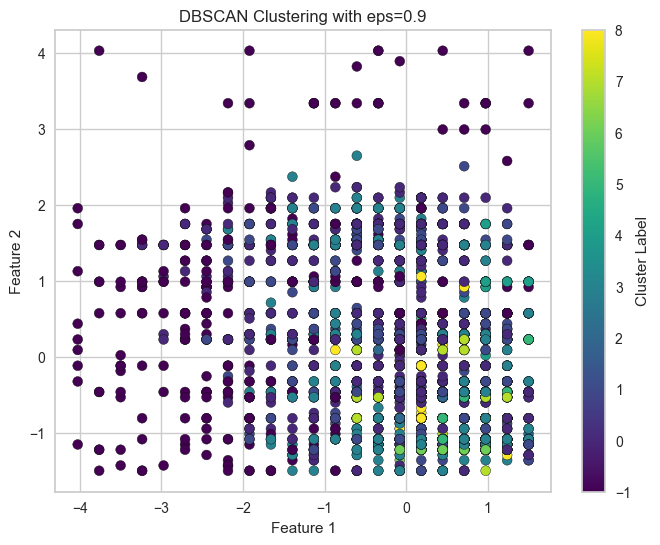

In [114]:
# 5. Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [54]:
X['dbscan'] = clusters

<Axes: xlabel='Year', ylabel='Engine_Size'>

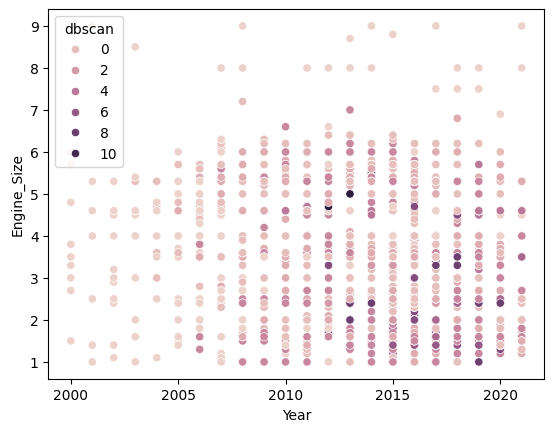

In [55]:
sns.scatterplot(data = X , x = 'Year', y = 'Engine_Size', hue = 'dbscan')

<Axes: xlabel='Mileage', ylabel='Engine_Size'>

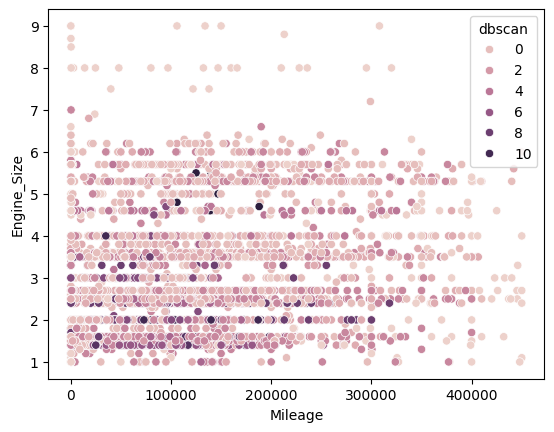

In [56]:
sns.scatterplot(data = X , x = 'Mileage', y = 'Engine_Size', hue = 'dbscan')

<Axes: xlabel='Mileage', ylabel='Type_Accent'>

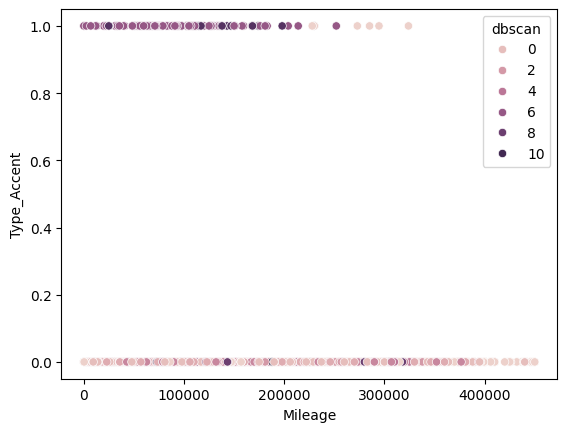

In [57]:
sns.scatterplot(data = X , x = 'Mileage', y = 'Type_Accent', hue = 'dbscan')